To ensure that a regression analysis is valid and reliable, we must verify that the following four key assumptions are met:

1. Linearity:
There should be a linear relationship between the independent variable(s) and the dependent variable. This ensures that a linear model is appropriate to describe the relationship.

2. Independence:
All observations must be independent from one another. In time series data, this means that there should be no autocorrelation (i.e., past values should not influence future errors).

3. Homoscedasticity:
The variance of the residuals (errors) should remain constant across all levels of the independent variable(s). This implies that the model has consistent accuracy throughout.

4. Normality of Residuals:
The residuals should be approximately normally distributed (i.e., follow a bell-shaped curve). This assumption allows for accurate confidence intervals and hypothesis testing.

These assumptions are crucial for interpreting the coefficients and statistical significance of a linear regression model. If they are violated, the model's predictions and conclusions may be misleading.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import sklearn as sk

1. We are going to verify our first assumption with the regression analysis we previously made with the Relative Strength Indicator (RSI). 

To test **linearity**, we typically create a **scatter plot** of the predicted values versus the residuals. This helps us visually assess whether the residuals are randomly scattered around zero across all levels of the predicted values.

If the points form a random, patternless cloud centered around the horizontal axis (residual = 0), the assumption of linearity is likely satisfied.
However, if there is a clear pattern, curve, or funnel shape, it may indicate that the relationship between the independent and dependent variables is not truly linear, and a different model might be more appropriate

2. We are going to verify our second assumption in regression analysis using the model we previously built with the Relative Strength Index (RSI) as the independent variable.

To test **Independence of residuals**, we will use a **lag plot** of the residuals. This visual tool helps detect autocorrelation, which would violate the assumption that residuals are independent from one another.

If the residuals are independent, the points in the lag plot should appear randomly scattered. A visible pattern (e.g., a linear or curved shape) would suggest that residuals are correlated over time, indicating autocorrelation.

**We are using lag_plot from the module pandas.plotting**

NOTE:

We could also use the **Durbin-Watson test**, a statistical test commonly applied to the residuals of a regression model. This test specifically checks for the presence of autocorrelation (i.e., correlation between residuals across time), which violates the assumption that residuals should be independent of one another.

The Durbin-Watson statistic ranges from 0 to 4:

- A value around 2 suggests no autocorrelation.

- A value less than 2 indicates positive autocorrelation.

- A value greater than 2 indicates negative autocorrelation.

3. We are going to verify our third assumption in regression analysis using the model we previously built with the Relative Strength Index (RSI) as the independent variable.

Yahoo Finance auto-adjusts prices, which can mask heteroscedasticity in the data. Therefore, we set auto_adjust=False to conduct our analysis properly.

To test **Homoscedasticity**, we use a residuals vs. predicted values plot.

This plot helps us check whether the variance of the residuals remains roughly constant across all levels of the predicted values. Ideally, the residuals should appear randomly scattered around zero with no discernible pattern. If we observe a **funnel shape or systematic pattern**, it indicates **heteroscedasticity**, violating the assumption of constant variance.

4. We are going to verify our fourth and last assumption in regression analysis using the model we previously built with the Relative Strength Index (RSI) as the independent variable.

To test the assumption of **normality of residuals**, we examine whether the residuals are approximately normally distributed around zero.

We will use a **histogram** of the residuals:

In the histogram, the residuals should resemble a bell-shaped curve.

If the residuals are not normally distributed, it could affect hypothesis testing (like t-tests) and confidence intervals, but the estimation of the regression coefficients themselves remains unbiased.



[*********************100%***********************]  1 of 1 completed


Coefficient: 0.004795257862969308
Intercept: -0.046683725982880786
R-squared: 0.0005488456662439134


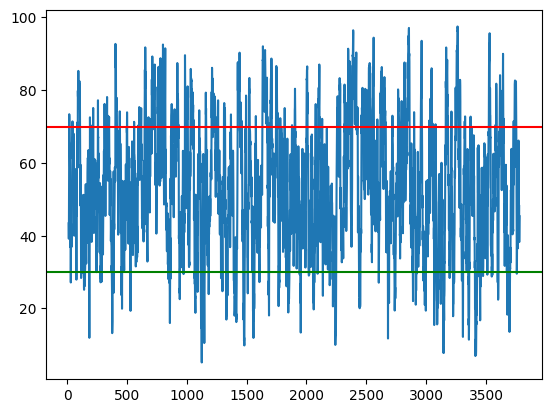

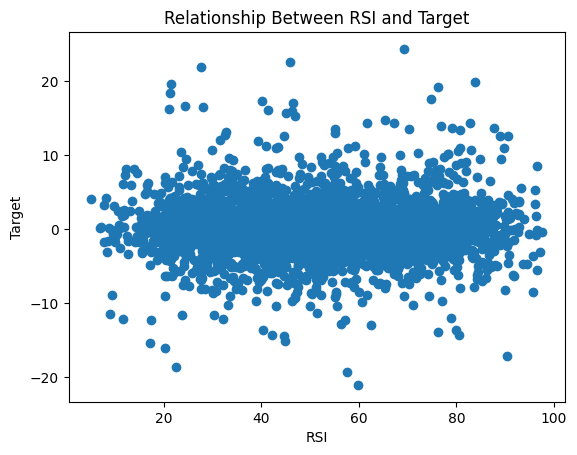

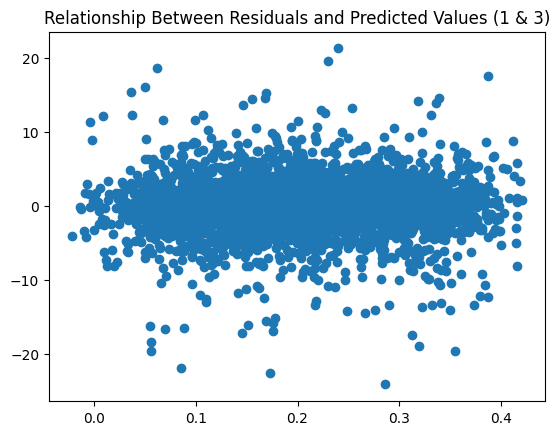

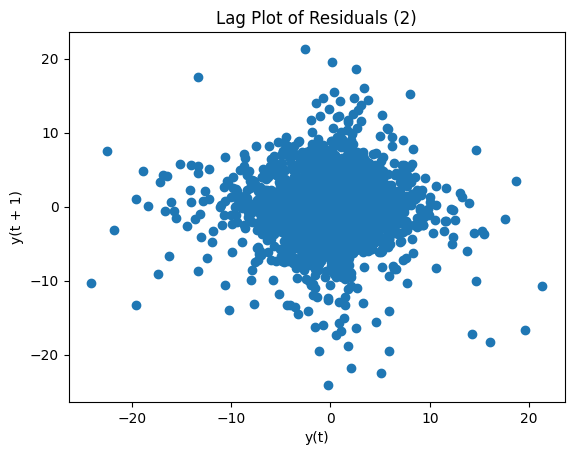

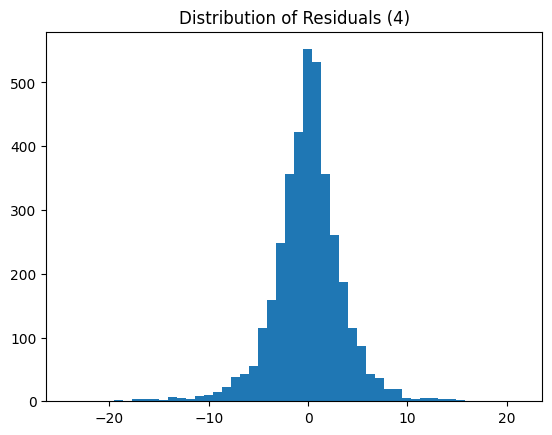

In [ ]:
# General parameters
TICKER = 'TSLA'
INTERVAL = '1d'
SHIFT = 1
STRATEGY = 'RSI'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# RSI parameters
RSI_LENGTH = 14
OVERBOUGHT = 70 
OVERSOLD = 30

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD, auto_adjust = False) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_target(df, shift = SHIFT):

    df[f'Close + {shift}'] = df['Close'].shift(-shift) 
    df['Target'] = (df[f'Close + {shift}'] - df['Close']) / df['Close'] * 100
    
    return df

def add_RSI(df, lenght = RSI_LENGTH):

    price_change = df['Close'].diff() #diff() => current value - previous value

    # Separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = - price_change.where(price_change < 0, 0)

    # Average gain vs loss
    avg_gain = gain.rolling(window = lenght).mean()
    avg_loss = loss.rolling(window = lenght).mean()

    # Calculate RSI
    rs = avg_gain/avg_loss # what % of the avg loss is the avg gain
    rsi = 100 - (100/(1 + rs))

    df['RSI'] = rsi

    # plot the RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green') 

    return df.dropna()

def generate_linear_regression(df, features ='RSI', target ='Target'):

    subset = df[[features, target]].dropna() 

    X = subset[[features]].values  # X must be a 2D array for sklearn (features) → shape (n_samples, 1)
    y = subset[target].values    # Y can be a 1D array (target variable) → shape (n_samples,)

    model = sk.linear_model.LinearRegression()  

    model.fit(X, y)  

    y_pred = model.predict(X)  # Generate predictions for Y based on the fitted model

    r2 = sk.metrics.r2_score(y, y_pred)  # Compute R² to measure how well the model explains variability in Y

    # Coefficient and intercept variable
    coef = model.coef_[0]
    intercept = model.intercept_

    # Print model parameters
    print(f'Coefficient: {coef}') 
    print(f'Intercept: {intercept}') 
    print(f'R-squared: {r2}') 

    # Plot the relationship between features (X) and Target (Y)
    plt.figure()
    plt.scatter(X, y)
    plt.xlabel(f'{features}')
    plt.ylabel(f'{target}')
    plt.title(f'Relationship Between {features} and {target}')

    return coef, intercept

def test_linearity_homoscedasticity(df, coef, intercept, strategy = STRATEGY):

    df['Predictions'] = intercept + coef * df[f'{strategy}'] 

    df['Residuals'] = df['Target'] - df['Predictions']

    # plot
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values (1 & 3)')

    return df

def test_independence(df):

    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals (2)')

    return df

def test_normality(df):
    plt.figure()
    plt.hist(df['Residuals'], bins = 50)
    plt.title('Distribution of Residuals (4)')

    return df

def validation_reg(df, coef, intercept, strategy = STRATEGY):

    df['Predictions'] = intercept + coef * df[f'{strategy}'] 
    df['Residuals'] = df['Predictions'] - df['Target']

    # Linearity and Homoscedastidy
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values (1 & 3)')

    # Independece (autocorrolation)
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals (2)')

    # Normality
    plt.figure()
    plt.hist(df['Residuals'], bins = 50)
    plt.title('Distribution of Residuals (4)')


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    fit_coef, fit_intercept = generate_linear_regression(df)
    df = validation_reg(df, coef = fit_coef, intercept = fit_intercept) 

    return df

df = main()
df